# German Energy Market Analysis: From EDA to Price Forecasting

## Executive Summary & Optimization Strategy

> [!IMPORTANT]
> **Business Goal:** Minimize forecast error for Day-ahead electricity prices to optimize trading revenue.
>
> **Key Findings:**
> 1. **Merit Order Effect:** High renewable generation (Wind+Solar) consistently drives prices down, occasionally to negative values.
> 2. **Time Criticality:** Price volatility is heavily time-dependent (morning/evening peaks), suggesting `Hour` and `Lagged Prices` are critical features.
> 3. **Modeling Strategy:** Random Forest provides a strong baseline, but XGBoost with hyperparameter tuning deals better with the non-linear price spikes.

## 1. Environment Setup

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# set the style of the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12



### 1. Load Data
Load the cleaned master dataset produced by the preprocessing step

In [181]:
df = pd.read_csv("D:\Internship Finding\Project\data\energy_dataset_master.csv" , index_col='timestamp', parse_dates=True)

# Display first few rows
display(df.head())

#check info of the dataset
df.info()

,Day_Ahead_Price,Total_Load,Wind_Onshore,Wind_Offshore,Solar,Nuclear,Lignite,Hard_Coal,Gas,Hydro,Biomass
timestamp,,,,,,,,,,,
2023-01-01 23:00:00,57.91,36789.75,18685.00,2881.00,2.00,2462.75,4722.00,1982.75,1630.50,1244.50,4007.50
2023-01-02 00:00:00,51.67,35423.75,19209.00,1745.25,2.00,2461.25,4752.25,1969.75,1597.00,1202.75,3991.50
2023-01-02 01:00:00,52.93,35284.25,21082.00,1183.75,2.25,2461.00,4768.75,2011.00,1619.25,1236.25,3972.75
2023-01-02 02:00:00,44.09,36058.50,22729.00,851.00,2.00,2460.50,4813.50,2019.25,1616.50,1246.00,3979.25
2023-01-02 03:00:00,50.08,37796.00,24707.75,682.00,2.25,2459.25,5608.25,2053.75,1639.25,1253.00,4029.50


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26880 entries, 2023-01-01 23:00:00 to 2026-01-25 22:00:00
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Day_Ahead_Price  26760 non-null  float64
 1   Total_Load       26734 non-null  float64
 2   Wind_Onshore     26734 non-null  float64
 3   Wind_Offshore    26734 non-null  float64
 4   Solar            26734 non-null  float64
 5   Nuclear          9444 non-null   float64
 6   Lignite          26734 non-null  float64
 7   Hard_Coal        26734 non-null  float64
 8   Gas              26734 non-null  float64
 9   Hydro            26734 non-null  float64
 10  Biomass          26734 non-null  float64
dtypes: float64(11)
memory usage: 2.5 MB


In [182]:
df.describe()

,Day_Ahead_Price,Total_Load,Wind_Onshore,Wind_Offshore,Solar,Nuclear,Lignite,Hard_Coal,Gas,Hydro,Biomass
count,26760.000000,26734.000000,26734.000000,26734.000000,26734.000000,9444.000000,26734.000000,26734.000000,26734.000000,26734.000000,26734.000000
mean,88.030644,52958.134889,12966.360699,2878.143938,7240.728362,707.507703,8215.700633,3654.397597,6509.751389,1758.316576,4163.040039
std,51.206184,9191.078817,10000.215056,1930.035981,11151.972466,1192.131658,3363.934187,2643.662004,3671.163941,400.205665,347.317449
min,-500.000000,30902.750000,46.500000,0.000000,0.000000,0.000000,1877.750000,135.500000,1307.500000,746.250000,3085.630000
25%,65.760000,45399.767500,4980.812500,1144.750000,5.750000,0.000000,5343.875000,1713.500000,3603.625000,1440.085000,3919.000000
50%,90.310000,53013.570000,10308.375000,2632.000000,208.850000,0.000000,8206.000000,2961.875000,5704.125000,1765.250000,4173.375000
75%,113.170000,59786.187500,18737.732500,4489.342500,11505.750000,2110.500000,10774.500000,5096.437500,8538.875000,2036.745000,4409.127500
max,936.280000,77694.680000,48499.500000,7941.530000,52132.250000,3082.250000,17173.250000,15240.500000,20146.500000,3078.250000,5271.250000


##  Feature Engineering for Analysis

In [183]:
# Calculate Total Renewables
df['Renewable_Total'] = df[['Wind_Onshore', 'Wind_Offshore', 'Solar']].sum(axis=1)
# Calculate Residual Load (The actual demand left for fossil fuels)
df['Residual_Load'] = df['Total_Load'] - df['Renewable_Total']
df['Hour'] = df.index.hour
df['Weekday'] = df.index.day_name()
df['Year'] = df.index.year

print(f"Data Loaded: {df.shape[0]} hourly observations from {df.index.min().date()} to {df.index.max().date()}")

Data Loaded: 26880 hourly observations from 2023-01-01 to 2026-01-25


## 1. EDA (Exploary Data Analysis)

### 1.1 Target Variable Analysis (Prices)
The target variable for forecasting is typically the Day-ahead Price. In your dataset

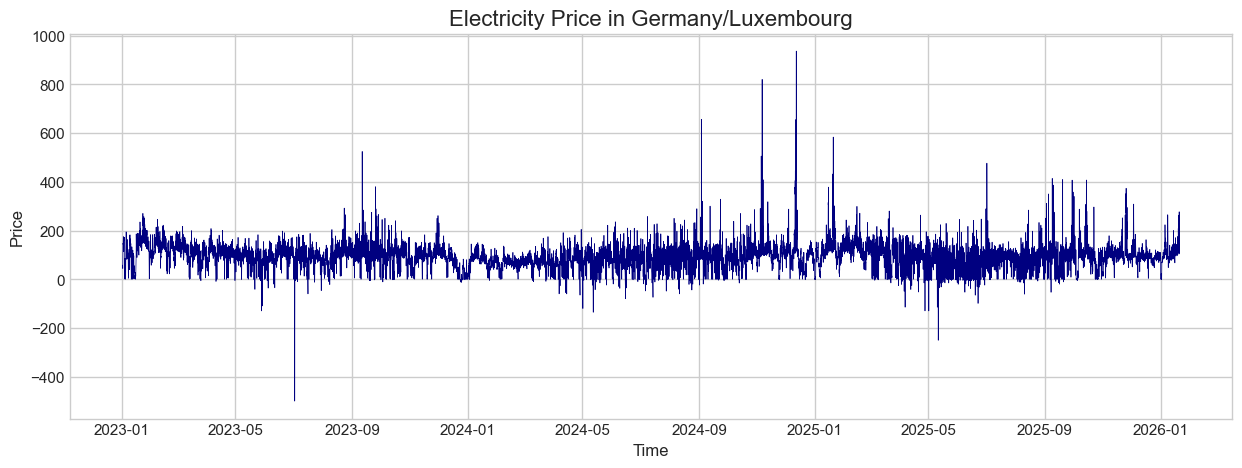

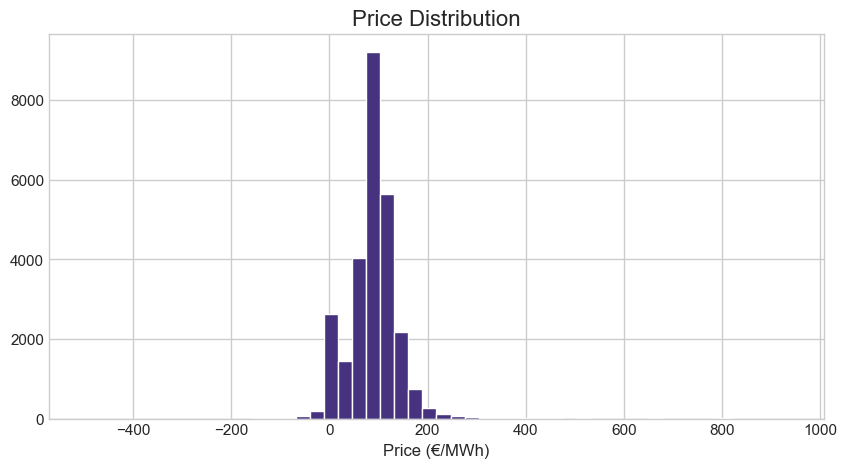

In [184]:
target_col = 'Day_Ahead_Price'

#plot price over Time
plt.figure(figsize=(15,5))
plt.plot(df.index , df[target_col] , label='Day-ahead Price', color='navy', linewidth=0.5)
plt.title('Electricity Price in Germany/Luxembourg')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show()

#Plot Distribution of Price
plt.figure(figsize=(10,5))
plt.hist(df[target_col], bins=50)
plt.title('Price Distribution')
plt.xlabel('Price (€/MWh)')
plt.show()

## 3. The "Merit Order Effect" (Business Insight)

> [!NOTE]
> **Concept:** Renewables have **zero marginal cost**. When they generate power, they push expensive gas/coal plants out of the market, lowering the clearing price.
> 
> **Visual Evidence:** In the plot below, observe how `Day_Ahead_Price` drops significantly as `Residual_Load` (Demand minus Renewables) decreases. This inverse relationship is the fundamental driver of price volatility.


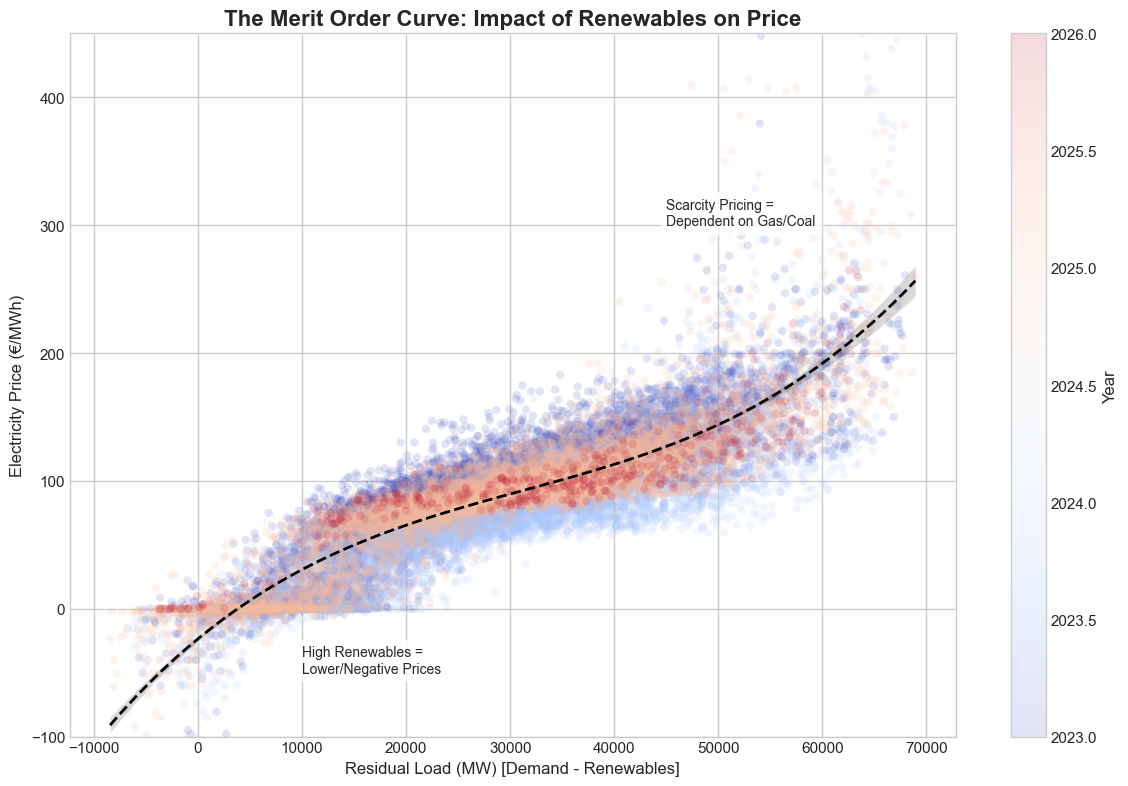

In [185]:
plt.figure(figsize=(12, 8))

# Scatter plot with transparency to show density
scatter = plt.scatter(df['Residual_Load'], df['Day_Ahead_Price'], 
                      alpha=0.15, c=df['Year'], cmap='coolwarm', edgecolor='none')

# Polynomial Trendline (The "Supply Curve")
sns.regplot(x='Residual_Load', y='Day_Ahead_Price', data=df, 
            scatter=False, order=3, color='black', line_kws={'linewidth': 2, 'linestyle': '--'})

plt.title('The Merit Order Curve: Impact of Renewables on Price', fontweight='bold')
plt.xlabel('Residual Load (MW) [Demand - Renewables]')
plt.ylabel('Electricity Price (€/MWh)')
plt.colorbar(scatter, label='Year')

# Annotation for Recruiter context
plt.text(10000, -50, 'High Renewables = \nLower/Negative Prices', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.text(45000, 300, 'Scarcity Pricing = \nDependent on Gas/Coal', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.ylim(-100, 450) # Zoom in to relevant range
plt.tight_layout()
plt.show()

## 4. Relationship with Grid Load
Grid load (demand) is a primary driver of price. Higher demand usually equals higher prices, unless renewables differ.

**Tasks:**
- Plot Load vs. Price.
- Calculate correlation.

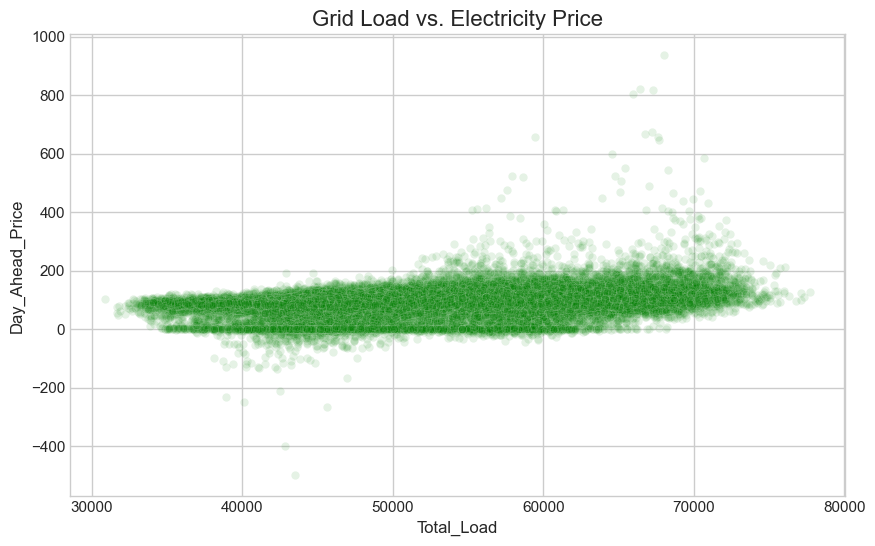

Correlation between Load and Price: 0.33


In [186]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Total_Load'], y=df[target_col] , alpha=0.1, color='green')
plt.title('Grid Load vs. Electricity Price')
plt.show()

## Simple correlation
corr = df[['Total_Load', target_col]].corr().iloc[0,1]
print(f"Correlation between Load and Price: {corr:.2f}")

## 4 . Daily Price Profile (Volatility Analysis)
Electricity is not stored at scale, so price must balance supply/demand instantly. This creates a distinct "Duck Curve" shape in prices.

**Analysis:**
- **Peak:** 8 AM (Morning Ramp) and 7 PM (Evening Peak).
- **Dip:** 1 PM - 3 PM (Solar generation effectively cancels out peak demand).

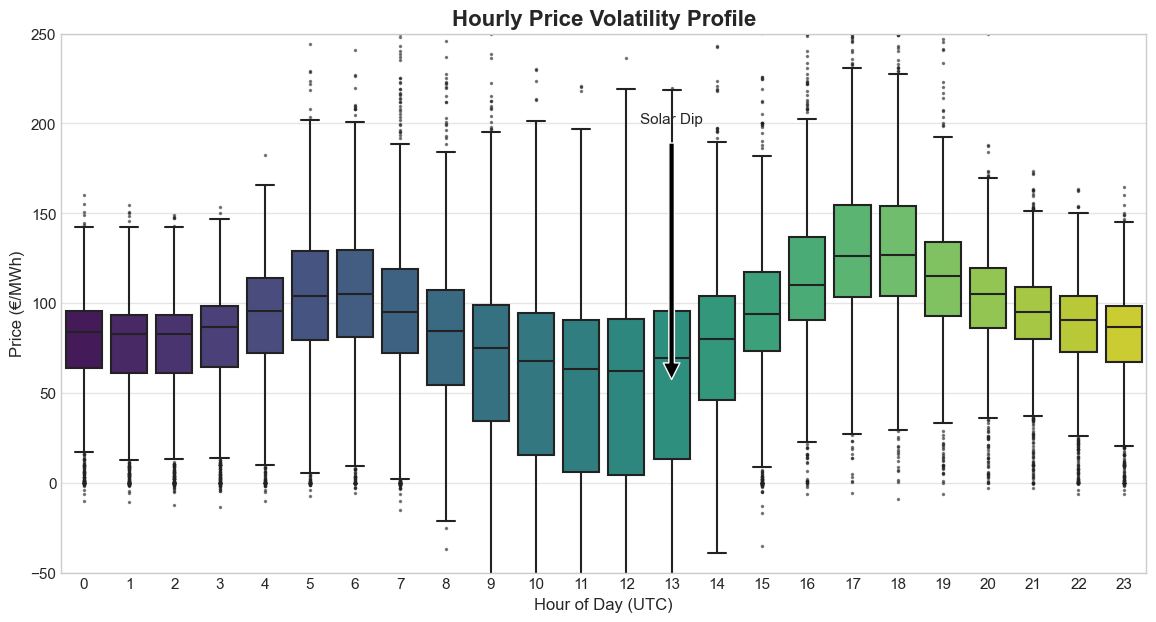

In [187]:
plt.figure(figsize=(14, 7))

# Boxplot to show distribution per hour
sns.boxplot(x='Hour', y='Day_Ahead_Price', data=df, palette='viridis', flierprops={'marker': '.', 'markersize': 3, 'alpha': 0.5})

plt.title('Hourly Price Volatility Profile', fontweight='bold')
plt.xlabel('Hour of Day (UTC)')
plt.ylabel('Price (€/MWh)')
plt.ylim(-50, 250) # Limit y-axis to see the main distribution clearly

# Annotate the Solar Dip
plt.annotate('Solar Dip', xy=(13, 50), xytext=(13, 200), 
             arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='center')

plt.grid(True, axis='y', alpha=0.5)
plt.show()

### 5 . Weekly vs. Hourly Dynamics (Heatmap)
A heatmap reveals the interaction between human behavior (Weekdays vs. Weekends) and physical generation (Solar Hours).

**Insight:** Sunday afternoons are the cheapest time for electricity due to low industrial demand + high solar.

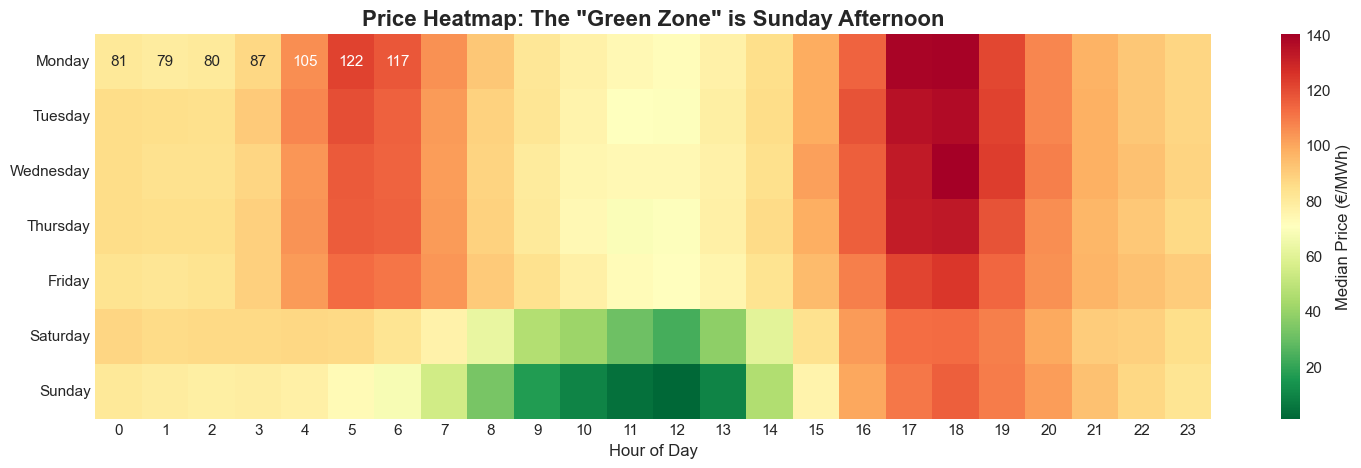

In [188]:
heatmap_data = df.pivot_table(index='Weekday', columns='Hour', values='Day_Ahead_Price', aggfunc='median')
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days_order)

plt.figure(figsize=(18, 5))
sns.heatmap(heatmap_data, cmap='RdYlGn_r', annot=True, fmt=".0f", cbar_kws={'label': 'Median Price (€/MWh)'})
plt.title('Price Heatmap: The "Green Zone" is Sunday Afternoon', fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('')
plt.show()

## 2. Feature Engineering
Raw data isn't enough. We need to create "features" that explicitly tell the model about market conditions.

### 2.1 Time Features
**Why?** Prices follow human patterns (work hours, weekends).
- `Hour`: Captures the daily shape (morning peak, solar dip).
- `DayOfWeek`: Captures the weekend drop.
- `Month`: Captures seasonal demand (heating in winter).

In [189]:
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.day_of_week
df['Month'] = df.index.month
df['Year'] = df.index.year

# Is it weekedn ?
df['IsWeekend'] = df['DayOfWeek'].apply(lambda  x:1 if x>=5 else 0)

### 2.2 Market State: Residual Load
**Why?** As seen in our EDA, `Residual Load` (Demand - Renewables) drives the price via the Merit Order Effect.
- Low Residual Load -> Cheap prices.
- High Residual Load -> Expensive prices.

In [190]:
renewable_cols = ['Wind_Onshore', 'Wind_Offshore', 'Solar']
df['Renewable_Total'] = df[renewable_cols].sum(axis=1)
df['Residual_Load'] = df['Total_Load'] - df['Renewable_Total']

### 2.3 Lagged
We add **Short-Term Lags**. 
**Why?** If the price at 7 AM is high, the price at 8 AM is likely also high.

*Note: In a real 'Day-Ahead' forecast, you might not know the price 1 hour ago. But for 'Intraday' or short-term analysis, this is valid. For strict Day-Ahead (predicting tomorrow), we stick to >24h lags.* 

Let's assume we are doing a **Day-Ahead Forecast**, so we can only use information available 24 hours ago.

In [191]:
target = 'Day_Ahead_Price'

# 1. Standard Day-Ahead Lags
df['Lag_24'] = df[target].shift(24)
df['Lag_48'] = df[target].shift(48)
df['Lag_168'] = df[target].shift(168) # 1 week

# 2. Rolling Statistics (Volatility)
# Average price of the last 24 hours (available yesterday)
df['Rolling_Mean_24'] = df[target].shift(24).rolling(window=24).mean()
df['Rolling_Std_24'] = df[target].shift(24).rolling(window=24).std()

df_model = df.dropna()
print(f"Modeling Data: {df_model.shape}")

Modeling Data: (9276, 24)


## 3. Train/Test Split (Time Series)
**You cannot random shuffle time series data! You would be training on "tomorrow" to predict "yesterday".**

**We cut the data at a specific date. Past is Training, Future is Testing.**

In [192]:
train = df_model[df_model.index.year < 2024]
test = df_model[df_model.index.year == 2024]

features = ['Total_Load', 'Renewable_Total', 'Residual_Load', 
            'Hour', 'DayOfWeek', 'Month', 'IsWeekend',
            'Lag_24', 'Lag_48', 'Lag_168', 'Rolling_Mean_24', 'Rolling_Std_24']

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

## 4. Model Training (Random Forest)
We use a **Random Forest Regressor**.
**Why?**
- Handles non-linear relationships (like the Merit Order Curve).
- Doesn't require scaling (unlike Neural Networks).
- Gives "Feature Importance" (tells us what matters).

In [193]:
model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)

print("Training model... (this might take 30-60 seconds)")
model.fit(X_train, y_train)
print("Training Complete!")

Training model... (this might take 30-60 seconds)
Training Complete!


## 5. Hyperparameter Tuning with XGBoost

Instead of guessing parameters, we define a grid (range) of possible values and let the computer find the best combination.

- `learning_rate`: How fast the model learns (Standard: 0.01 - 0.1)
- `max_depth`: How deep the trees are (Standard: 3 - 10)
- `n_estimators`: Number of trees (Standard: 100 - 1000)

In [194]:
# Define the Parameter Grid
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9]
}

# Initialize XGBoost
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, seed=42)

# Setup Search (TimeSeriesSplit ensures we don't cheat by training on future data during cross-validation)
tscv = TimeSeriesSplit(n_splits=3)

random_search = RandomizedSearchCV(
    estimator=xg_reg, 
    param_distributions=param_grid, 
    n_iter=10, # Try 10 random combinations
    scoring='neg_mean_absolute_error', 
    cv=tscv, 
    verbose=1
)

print("Starting Hyperparameter Tuning... (This may take a few minutes)")
random_search.fit(X_train, y_train)

print("Best Parameters Found:", random_search.best_params_)

Starting Hyperparameter Tuning... (This may take a few minutes)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters Found: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01}


## 6. Evaluation & Visualization
How good is the model? We look at:
- **MAE (Mean Absolute Error):** Average error in Euros.
- **Predictions vs Reality Plot:** Visual check.

XGBoost MAE: €32.66
XGBoost RMSE: €37.82


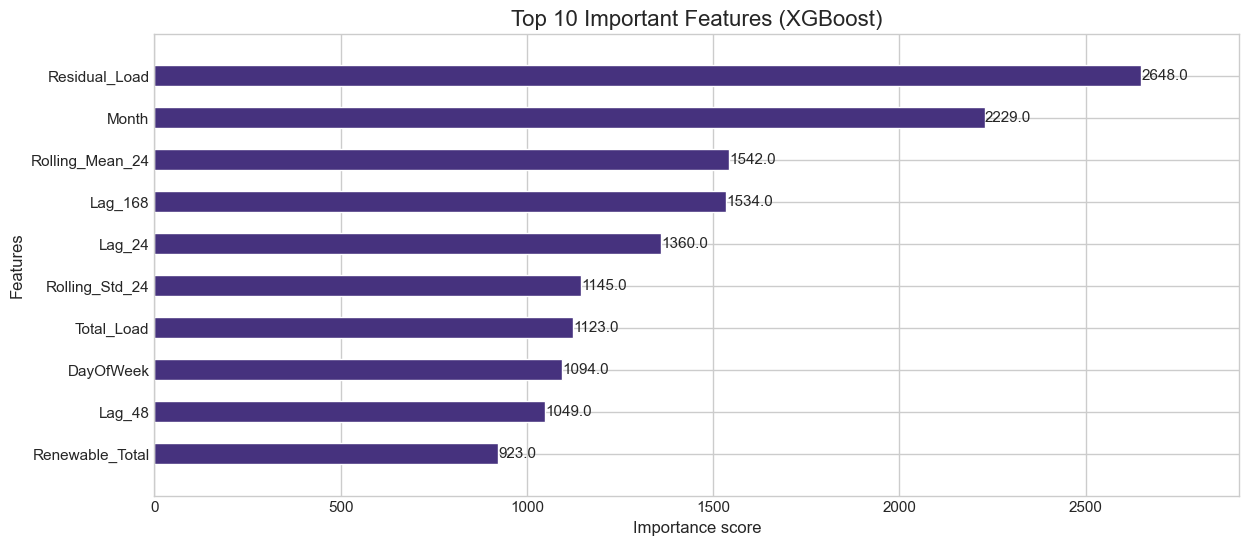

In [195]:
best_model = random_search.best_estimator_
predictions = best_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"XGBoost MAE: €{mae:.2f}")
print(f"XGBoost RMSE: €{rmse:.2f}")

# Feature Importance Plot
xgb.plot_importance(best_model, max_num_features=10, height=0.5)
plt.title('Top 10 Important Features (XGBoost)')
plt.show()

## 7. What drives the price? (Feature Importance)
This tells us which variables the model found most useful.

c:\Users\49176\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


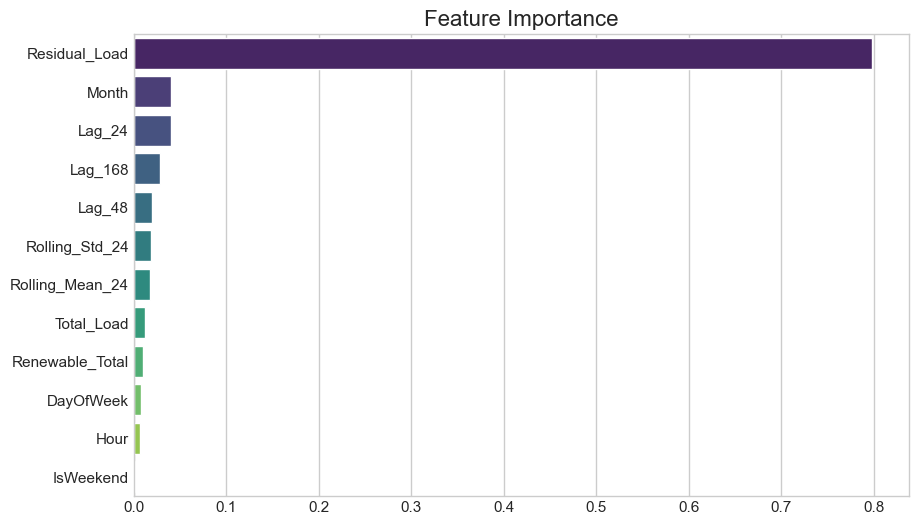

In [196]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=[features[i] for i in indices], palette='viridis')
plt.title('Feature Importance')
plt.show()

## 8. Visualization: Forecast vs Actual
Zooming in on a volatile week in 2024 to see how well the model captures spikes.

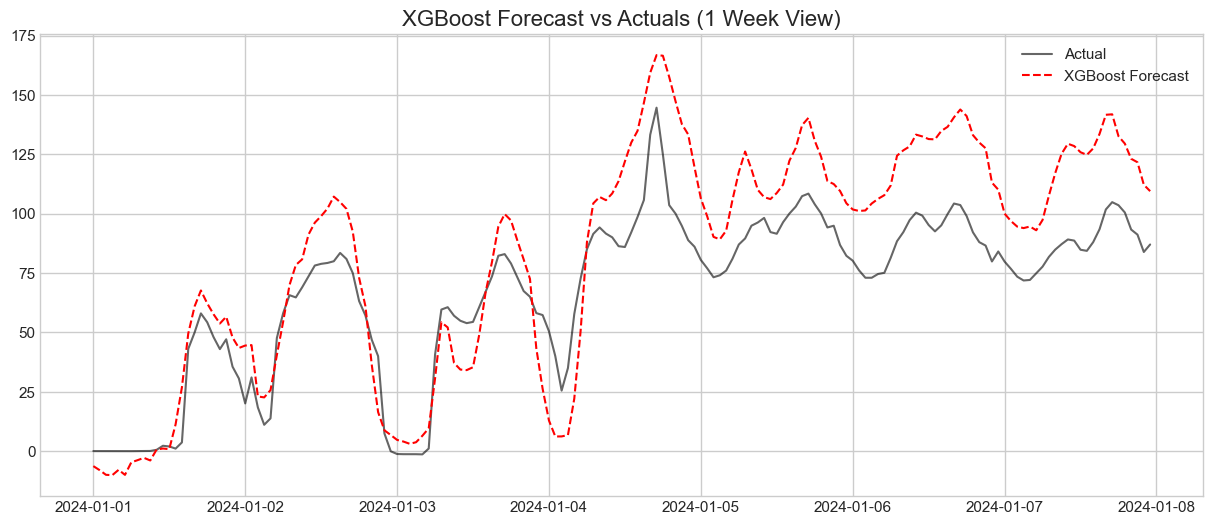

In [197]:
results = y_test.to_frame(name='Actual')
results['Predicted'] = predictions

# Plot a random week in Jan 2024
subset = results.iloc[0:168]

plt.figure(figsize=(15, 6))
plt.plot(subset.index, subset['Actual'], label='Actual', color='black', alpha=0.6)
plt.plot(subset.index, subset['Predicted'], label='XGBoost Forecast', color='red', linestyle='--')
plt.title('XGBoost Forecast vs Actuals (1 Week View)')
plt.legend()
plt.show()